In [52]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [53]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

with a basic neural network, 98 percent accuracy could be achived on mini MNIST dataset.with fastai image classes, close to 100 percent accuracy could be obtained. The fastai classes use variants of CNNs. This chapter will deal with CNNs and tweaks to improve its performance on variety of image-based datasets.

Feature engineering is a powerful tool machine learning practitioners have at their disposal. Feature transformation is the transformation of input data to a form which makes it easier to model. for example, in the tabular dataset, datepart was added to make it easier to find patterns.

An image has visually distinctive features. for example a 7 could be separated by 3 with its differences in diagonal edges . Instead of raw pixel wise comparison, the comparison with respect to these edges, diagonals etc could make the model easier to classify. 

This is achieved by mathematical operation called convolution. It is just a bunch of addition and multiplications - used throughout deep learning.

Convolutions in action with a small piece of code:

In [54]:
top_edge = torch.tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()
#this is called kernel in computer vision field - this is the filter which is convolved with the image

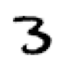

In [55]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [56]:
im3_t = tensor(im3)
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [57]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [58]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [59]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [60]:
def apply_kernel(row,col,kernel):
    return (im3_t[row-1:row+2, col-1:col+2] * kernel).sum()

In [61]:
apply_kernel(5,7,top_edge)

tensor(762.)

<AxesSubplot:>

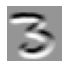

In [62]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3)

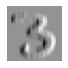

In [63]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

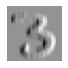

In [64]:
left_edge2 = tensor([[2,0,-1],
                    [2,0,-1],
                    [2,0,-1]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

Convolution operation is very important in image based deep learning models. It is built in in Pytorch , so it isn't necessary to build it from scratch everytime.

Pytorch expects four D input : (batch_size,in_channels, in_h, in_w) -> number of images in image, input_channels, size of image and four D output : (out_channels, in_channels, kW, kH) number of kernels, kernel width&height)

In [65]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float() 
# Diagonal kernels
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape


torch.Size([4, 3, 3])

In [66]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)
dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)

In [67]:
xb.shape,yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [68]:
xb,yb = to_cpu(xb),to_cpu(yb)

edge_kernels are of shape (4,3,3) i.e number of kernels(out_channels),size of kernel, additionally in_channels is to be added

In [69]:
edge_kernels.shape

torch.Size([4, 3, 3])

In [70]:
edge_kernels = edge_kernels.unsqueeze(1)

In [71]:
edge_kernels.shape

torch.Size([4, 1, 3, 3])

We have everything ready to pass to F.conv2D. This could then be trained to get the results

In [72]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

Pytorch uses the GPU to do all the work in parallel, applying multiple convolution kernels in parallel to images and then combining the results, Also, there are shortcuts to perform certain matrix operations . manually doing these operations sequentially is million times slower.

<AxesSubplot:>

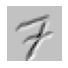

In [73]:
show_image(batch_features[63,2])

It is hard to figure out what kernels to use. Especially later layers are more complex transformations of data which encode abstract features of the images. We use SGD to get these kernels.

In [74]:
simple_net = nn.Sequential(nn.Linear(28*28,30), nn.ReLU(), nn.Linear(30,1))


In [75]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [76]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3,padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3,padding=1)
)
#input shape 28*28 is not required because convolution is applied on every pixel, only the input channels:1 and 
#number of kernels 30 are required along with kernel size,padding.


In [77]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

This is a classification problem , meaning thatthe last layer is has single neuron.this could be achived through some ways one of them being that the convolution layers with stride added susequently to make the last layer of size 1. 

In [78]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

When stride is increased from 1, the number of activations are being dropped by a factor of 4, decreasing the capacity per layer. Meaning that we increase the number of feature maps correspondingly. 
features : number of activations per grid cell after convolution

In [79]:
#construction of convolution neural network architecture (a simple one)
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

In [80]:
simple_cnn(xb).shape


torch.Size([64, 2])

In [81]:
learn = Learner(dls,simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [82]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [83]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.062208,0.059627,0.982826,00:15
1,0.020030,0.033300,0.991168,00:15


Receptive field : the amount of input image used in the activation of the kernel. The deeper we are in the network,for an activation in the kernel ,more receptive field is used. i.e to learn more abstract rich features, we need more of the input image. thus proprtionally, we should be adding more feauture maps to increase the computations.

Color images:

In [84]:
im = image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

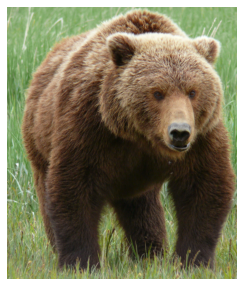

In [85]:
show_image(im);

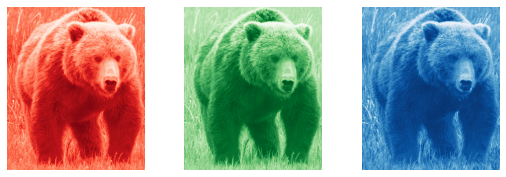

In [86]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)

In [87]:
# try to train a cnn to classify all the ten digits : instead of just 3 and 7
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

In [88]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

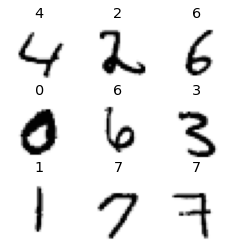

In [89]:
dls.show_batch(max_n=9, figsize=(4,4))

Earlier we had used a simple conv2d function to differentiate between 3 and 7.where 3X3 kernels were used i.e 9 pixel values are used to determine value at one location for 4 filters. now we have larger problem. so, more filters could be used.if 8 filters are used, for 9 pixels 8 values are decided. This will not help the neural network learn the patterns. the hack is to 25 pixels (5X5) for 8 filters.

In [90]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

In [91]:
from fastai.callback.hook import *

since we are using a simple model as baseline, we would want to look at the activation stats for the trainable layers, the call back function ActivationStats helps us with this by providing histograms and other data. Also, we use a higher learning rate 0f 0.06 to make the training faster as we have larger problem this time

In [92]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [93]:
learn=fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.611346,0.682665,0.797200,01:16


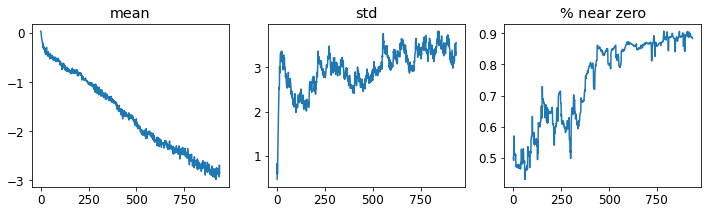

In [94]:

learn.activation_stats.plot_layer_stats(0)
     

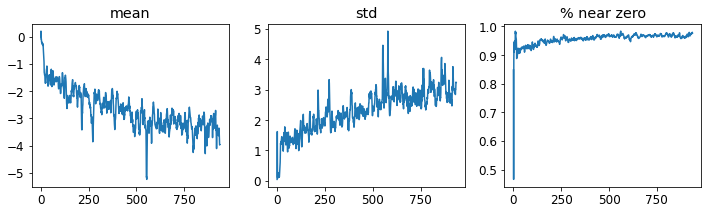

In [95]:
learn.activation_stats.plot_layer_stats(-2)

There is training instability .in the initial layer, the mean and std are not smooth(they are supposed to be!) ,percentageof activations near zero is too high in the initial layer and almost all in the last layer. We try to increase the batch size for better gradient computation. 

In [96]:

dls = get_dls(512)

In [97]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.305718,2.302505,0.113500,01:03


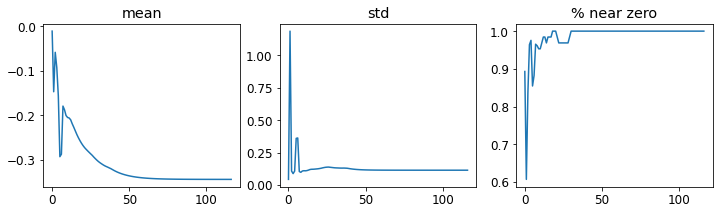

In [98]:
learn.activation_stats.plot_layer_stats(-2)

the problem still exists, so an approach is used Starting with a larger learning rate is dangerous (the training converges too fast without being stable) . also, it should not end at highre learning rate(minima could be missed this way).
So, 1 cycle training is proposed, starting with a lower learning rate and increase to higher rate(warmup) and then decrease to lower training rate(annealing).
this way two objectives are achieved:
1.faster training - super convergence
2. avoidance of overfitting - due to large learning rate , some sharp local minima are skipped and a generalization is found

the fit_one_cycle method in fastai implements this one-cycle method of modification of learning rates. This leads to better training stability, good generalization by finding an area of good losses which are robust to change in input.

In [99]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn
     

In [100]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.207949,0.075915,0.977300,01:04


Momentums are different orders of gradients which are used by optimizers for training. Momentum usually moves opposite to direction of learning rate. it not only takes step in direction of gradients,but also includes previous steps.

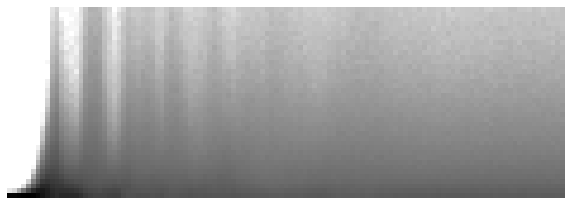

In [101]:
learn.activation_stats.color_dim(-2)

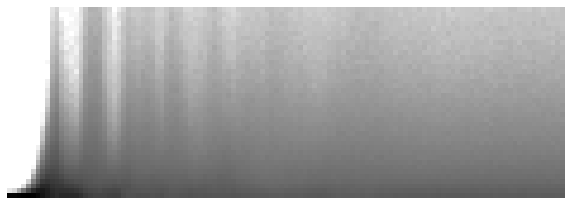

In [102]:
learn.activation_stats.color_dim(-2)

Insight : the log of the activations in histogram representation is plotted above. Initially, activations are all zero, thenthey increase exponentially and then fall back to zero,this happens a few times in the warm-up and then it spreads over a wide range. this can be prevented. the warm-up can be made more smoother for better training in the beginning.

This problem is referred to as internal covariate shift. The problem is proposed to be solved by batch-normalization.In each mini-batch, the input layer for each activation is normalized.

In [103]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [104]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.133790,0.057733,0.986700,01:06


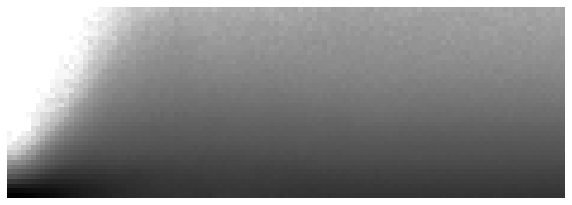

In [105]:
learn.activation_stats.color_dim(-4)

One possible explanation as to why batch-normalization might work is that batch normalization adds randomness to the layes while training making it robust to variations encountered in data and helps generalize well adding training stabbility.

In [106]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.187943,0.112958,0.965300,01:06
1,0.082214,0.064647,0.980200,01:06
2,0.049642,0.041125,0.987400,01:07
3,0.030723,0.032822,0.990700,01:07
4,0.015393,0.021767,0.993300,01:06
